## LIBRARIES

In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

from ISLP import confusion_table

import sklearn.linear_model as skl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

## -----set parameters-----

In [36]:
rnd = 22      # random state
alpha = 0     # best DT alpha
tuners = 2    # best RF number of tuner parameters
trees = 500   # RF trees to simulate

## --------------------------

## DATA

#### Load the data

In [37]:
# Load the data
df = pd.read_csv('smm636-GCW1_data.csv')
display(df)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [38]:
# Check for missing values
df.isnull().sum().sum()

0

In [39]:
# Convert the diagnosis column to a categorical variable
df['diagnosis'] = df['diagnosis'].astype('category')
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

In [40]:
# Drop the id column to not affect the model
df.drop(columns='id', inplace=True)

In [41]:
df.shape

(569, 31)

#### Under-smaple 'benighn' class to fit in 500 obs. requirement

In [42]:
# Separate the classes and undersample the benign class
df_m = df[df['diagnosis'] == 1]
df_b = df[df['diagnosis'] == 0].sample(n=500 - len(df_m), random_state=rnd)
df_sample = pd.concat([df_m, df_b])

print(f"Shape of the dataset: {df_sample.shape}"
      f"\n\nBefore: M = {len(df_m)}, B = {len(df[df['diagnosis'] == 0])} "
      f"\nProportions Before: M = {len(df_m)/569:.2f}, B = {(569-len(df_m))/559:.2f}"
      f"\n\nAfter: M = {len(df_m)}, B = {len(df_b)}"
      f"\nProportions After: M = {len(df_m)/500:.2f}, B = {len(df_b)/500:.2f}")

Shape of the dataset: (500, 31)

Before: M = 212, B = 357 
Proportions Before: M = 0.37, B = 0.64

After: M = 212, B = 288
Proportions After: M = 0.42, B = 0.58


#### Split the data into training and testing sets ensuring that the classes are balanced

In [43]:
diagnosis = df_sample['diagnosis']
features = df_sample.drop(columns=['diagnosis'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    diagnosis, 
    test_size=0.2, 
    random_state=rnd, 
    stratify = diagnosis
)

## DECISION TREE

#### Run the decision tree model using the best alpha value

In [45]:
# tuned_parameters = [{"ccp_alpha": np.arange(0, 0.01, 0.0001)}]  # the range was selected after multiple runs and minimise to find most precise alpha value in minimun time
# treeCV = GridSearchCV(DecisionTreeClassifier(random_state=rnd), 
#                       tuned_parameters, 
#                       scoring='roc_auc',                        # using accuracy instead of AUC since it is not possible to improve accuracy using a threshold for Decision Trees (there fore impossible to further reduce false negatives)
#                       cv=10)
# treeCV.fit(X_train, y_train)

# print("Best alpha found based on Accuracy:\n", 
#       treeCV.best_params_)

## Uncomment to se all iteratirated alphas
# print("\n\nGrid scores on validation set:")
# means = treeCV.cv_results_["mean_test_score"]
# stds = treeCV.cv_results_["std_test_score"]
# for mean, std, params in zip(means, stds, treeCV.cv_results_["params"]):
#        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

In [46]:
## Decision Tree model based on the best found alpha value
dt = DecisionTreeClassifier(ccp_alpha=alpha, random_state=rnd).fit(X_train, y_train)

#### Visualise the training decision tree

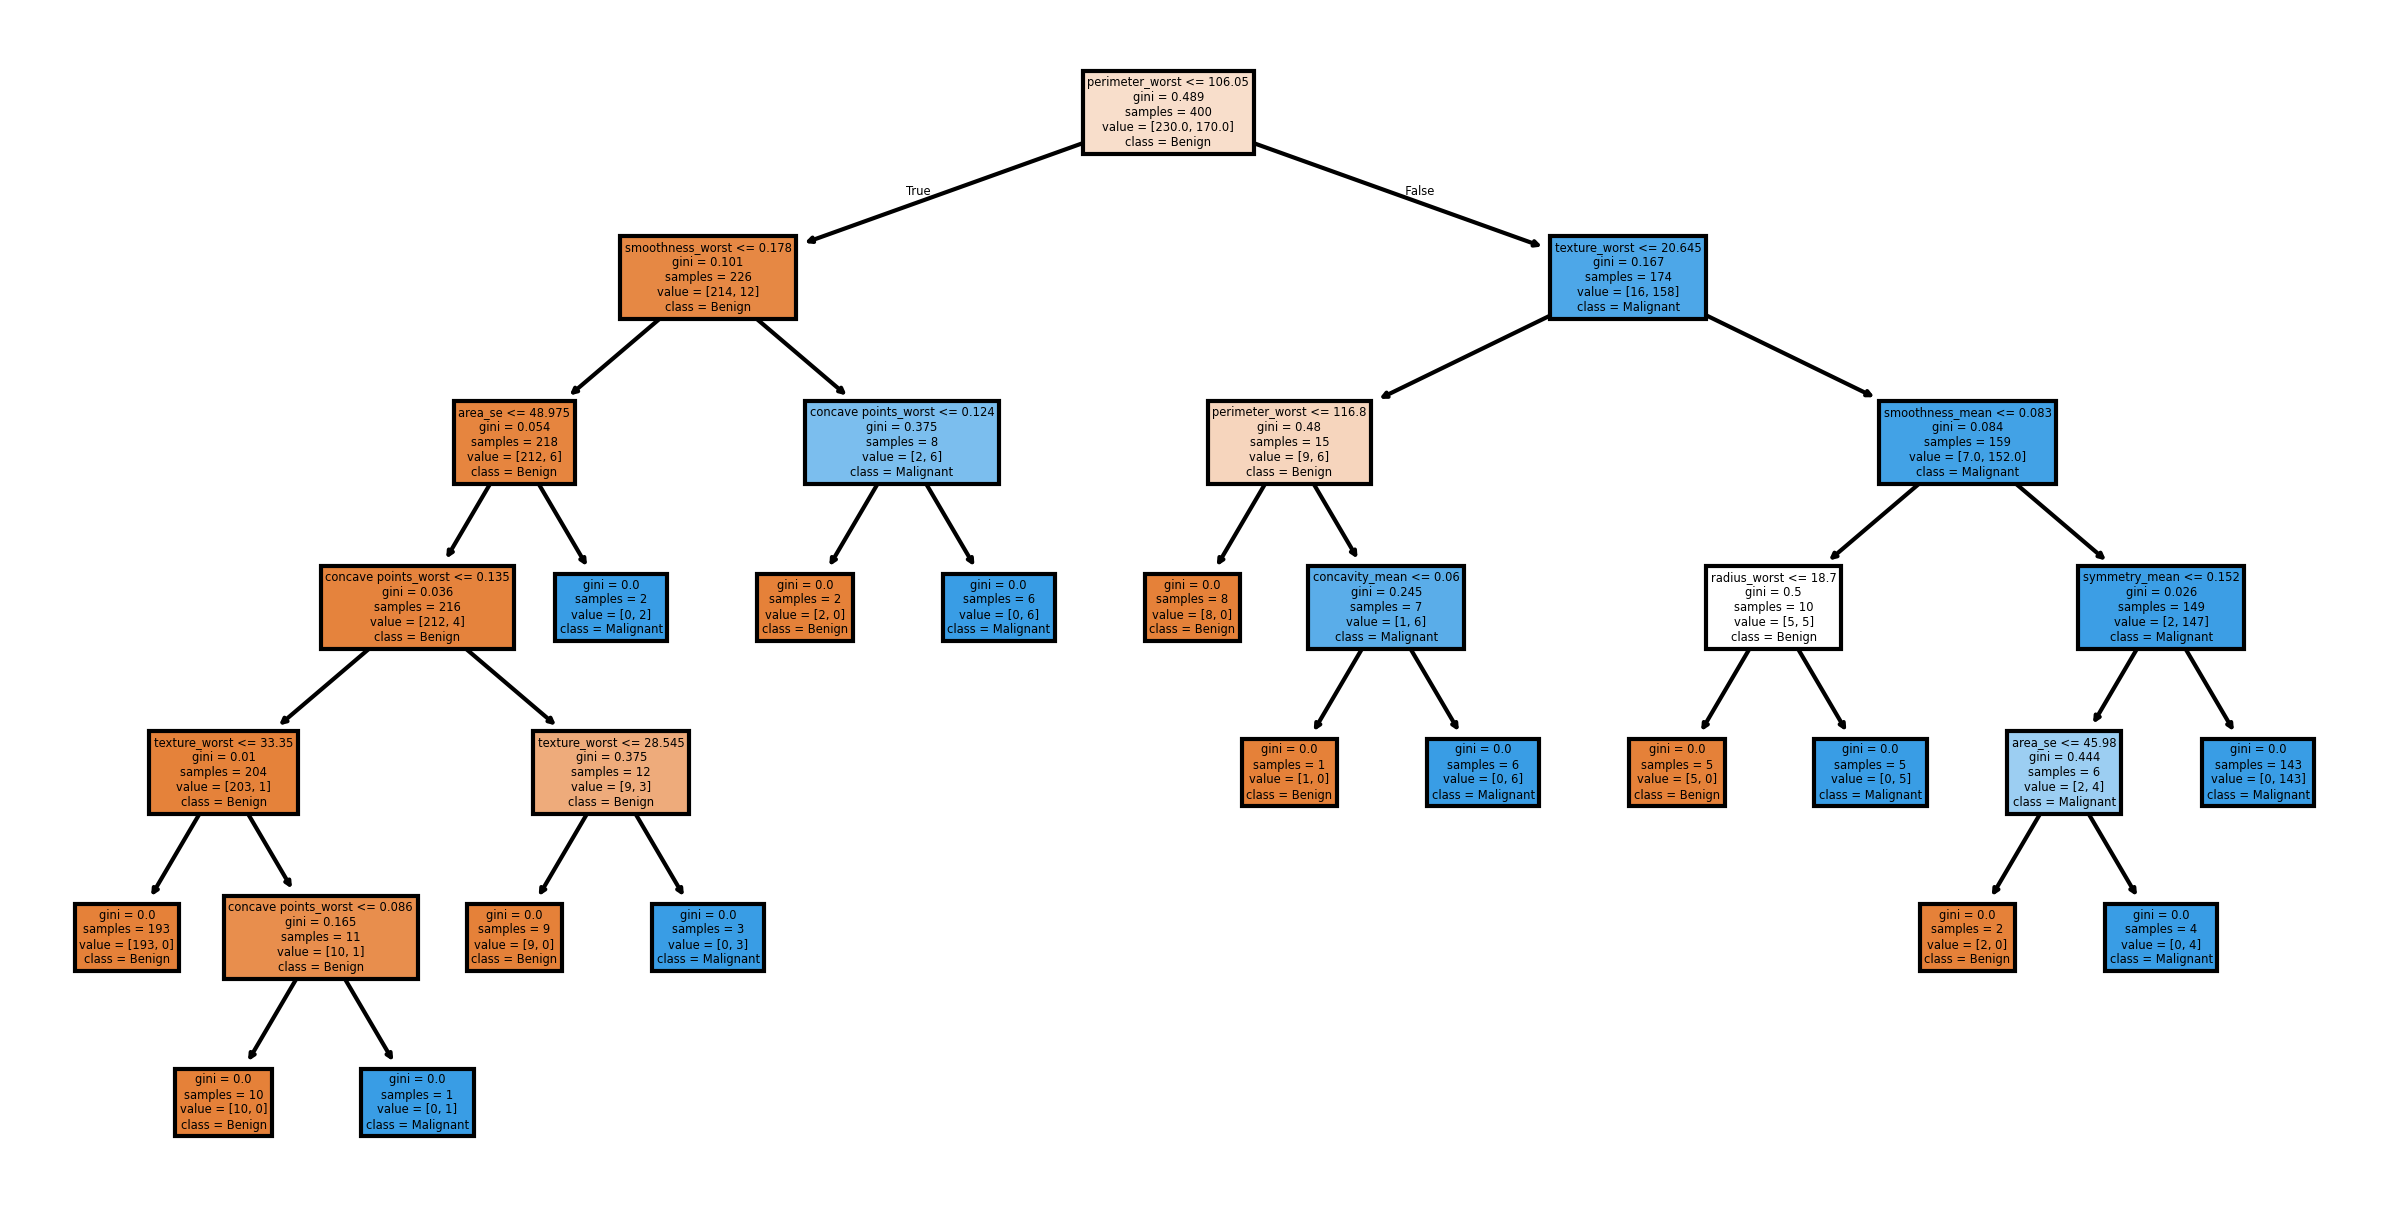

In [47]:
fn = X_train.columns
cn=['Benign','Malignant']
fig, axes = subplots(nrows = 1,
                     ncols = 1,
                     figsize = (10,5), 
                     dpi=300)
plot_tree(dt,
          feature_names = fn,
          class_names=cn,
          filled = True)
plt.show()

#### Check the accuracy of the decision tree model against the test sample

In [48]:
## Confusion matrix for the Decision Tree model
ypred_tree = dt.predict(X_test)
display(confusion_table(ypred_tree, y_test))

Truth,0,1
Predicted,,
0,54,5
1,4,37


In [49]:
## Cassification report for the Decision Tree model
print(classification_report(y_true=y_test, y_pred=ypred_tree))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92        58
           1       0.90      0.88      0.89        42

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [50]:
## AUC score for the Decision Tree model
yscores_tree = dt.predict_proba(X_test)
yscores_tree_m = yscores_tree[:, 1]
roc_auc_score(y_true=y_test,y_score=yscores_tree_m, multi_class="ovr", average="micro")

0.9059934318555009

#### Decision tree error across its size

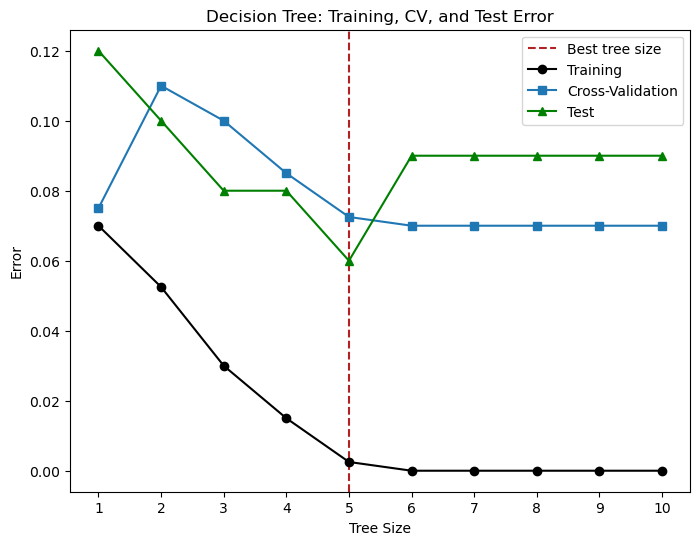

In [51]:
## Error rates for the Decision Tree model (Train vs Test vs Cross-Validation)
dt_train_err = []
dt_test_err = []
dt_cv_scores = []

tree_sizes = range(1, 11)  # Limit tree size for better visualization (P.S. best tree size == 5)

for size in tree_sizes:
    dt_tmp = DecisionTreeClassifier(max_depth=size, random_state=rnd)
    dt_tmp.fit(X_train, y_train)
    
    dt_train_err.append(1 - dt_tmp.score(X_train, y_train))
    dt_test_err.append(1 - dt_tmp.score(X_test, y_test))
    cv_score = cross_val_score(dt_tmp, X_train, y_train, cv=100, scoring='accuracy')
    dt_cv_scores.append(1 - np.mean(cv_score))

# Plot the error rates for the Decision Tree model
plt.figure(figsize=(8,6))
plt.errorbar(tree_sizes, dt_train_err, fmt='k-o', label='Training')
plt.errorbar(tree_sizes, dt_cv_scores, fmt='s-', label='Cross-Validation')
plt.errorbar(tree_sizes, dt_test_err, fmt='g-^', label='Test')
plt.axvline(x=5, color='firebrick', linestyle='--', linewidth=1.5, label='Best tree size')  # Best tree size

plt.xlabel('Tree Size')
plt.ylabel('Error')
plt.title('Decision Tree: Training, CV, and Test Error')
plt.legend()

plt.xticks(range(min(tree_sizes), max(tree_sizes) + 1, 1))

plt.show()


## RANDOM FOREST

#### Run the random forest model using the best number of randomised features

In [52]:
# tuned_parameters = [{"max_features": np.arange(1, 8, 1)}]  # the range was selected after multiple runs and minimise to find most precise number of tuning parameters in minimun time (change 8 to 31 for all features)
# rfCV = GridSearchCV(RandomForestClassifier(n_estimators=trees,
#                                            bootstrap=True,
#                                            oob_score=True,
#                                            random_state=rnd), 
#                     tuned_parameters, 
#                     scoring='roc_auc',  # using AUC as scoring metric to improve the ROC curve, which improves the accuracy better when setting specific threshold (compared to accuracy based model)
#                     cv=10)

# rfCV.fit(X_train, y_train)

# print("Best number of tuning parameters found based on AUC:\n", 
#       rfCV.best_params_)

## Uncomment to se all iteratirated number of tuning parameters
# print("\n\nGrid scores on validation set:")
# means = rfCV.cv_results_["mean_test_score"]
# stds = rfCV.cv_results_["std_test_score"]
# for mean, std, params in zip(means, stds, rfCV.cv_results_["params"]):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

In [53]:
for i in np.arange(1, 31, 1):    
# Train Random Forest using your parameters
    rf_threshold = RandomForestClassifier(n_estimators=trees,
                                max_features=tuners,
                                bootstrap=True,
                                oob_score=True,
                                random_state=rnd).fit(X_train, y_train)

    yprobs_threshold = rf_threshold.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Function to calculate and print classification report when TPR ('recall') for melignant (class 1) is 1
    def plot_confusion_matrix(threshold):
        ypred_threshold = (yprobs_threshold >= threshold).astype(int)
        report = classification_report(y_true=y_test, y_pred=ypred_threshold, output_dict=True)

        # Check if precision for class 1 is exactly 1 (specific to 'best number of tuning parameters' found above), removing 'and i == 2' will show all results, however they are identical
        if (report["1"]["recall"] == 1.0) and i == 2:
            print(f"==========max_features: {i}==========")
            print(f"Threshold: {threshold}")
            print(classification_report(y_true=y_test, y_pred=ypred_threshold))

    for threshold in np.arange(0.1, 1, 0.1):
        plot_confusion_matrix(threshold)

==========max_features: 2==========
Threshold: 0.1
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        58
           1       0.79      1.00      0.88        42

    accuracy                           0.89       100
   macro avg       0.90      0.91      0.89       100
weighted avg       0.91      0.89      0.89       100



In [54]:
## Confusion matrix for the Random Forest model with a mannually set threshold to have 100% TPR for the malignant class
ypred_threshold = (yprobs_threshold >= 0.1).astype(int)
confusion_table(ypred_threshold, y_test)

Truth,0,1
Predicted,,
0,47,0
1,11,42


In [55]:
## Random Forest model based on the best found number of tuning parameters
rf = RandomForestClassifier(n_estimators=trees,
                            max_features=tuners,
                            bootstrap=True,
                            oob_score=True,
                            random_state=rnd).fit(X_train,y_train)

#### Check the accuracy of the random forest model against the test sample

In [56]:
# predict test set labels
ypred_rf = rf.predict(X_test)
confusion_table(ypred_rf, y_test)

Truth,0,1
Predicted,,
0,55,4
1,3,38


In [57]:
print(classification_report(y_true=y_test, y_pred=ypred_rf))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        58
           1       0.93      0.90      0.92        42

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [58]:
yscores_rf = rf.predict_proba(X_test)
yscores_rf_m = yscores_rf[:, 1]
roc_auc_score(y_true=y_test, y_score=yscores_rf_m, multi_class="ovr", average="micro")

0.9917898193760263

#### Plot the importance of features

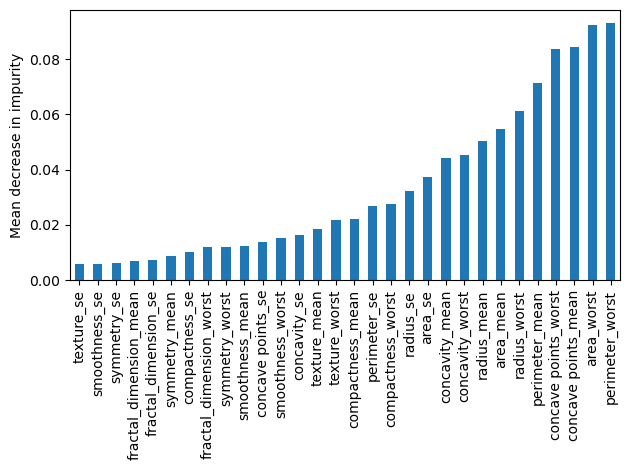

In [59]:
rf_importances = rf.feature_importances_
index = np.argsort(rf_importances)
forest_importances = pd.Series(rf_importances[index[-30:]],
                               index=rf.feature_names_in_[index[-30:]])

fig, aX = plt.subplots()
forest_importances.plot.bar()
aX.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Random forest error across number of trees

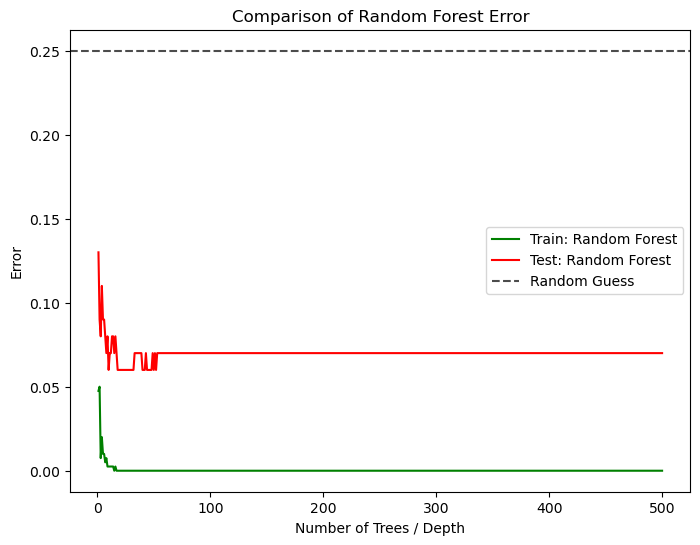

In [60]:
rf_train_err = []
rf_test_err = []

tree_numbers = range(1, trees+1)

for i in tree_numbers:
    rf = RandomForestClassifier(n_estimators=i, 
                                max_features=tuners, 
                                random_state=rnd)
    rf.fit(X_train, y_train)
    rf_train_err.append(1 - rf.score(X_train, y_train))
    rf_test_err.append(1 - rf.score(X_test, y_test))

# Plot error rates
plt.figure(figsize=(8,6))
plt.plot(range(1, trees+1), rf_train_err, 'g', label='Train: Random Forest')
plt.plot(range(1, trees+1), rf_test_err, 'r', label='Test: Random Forest')
plt.axhline(y=0.25, color='k', linestyle='--', alpha=0.7, label='Random Guess')
plt.xlabel('Number of Trees / Depth')
plt.ylabel('Error')
plt.title('Comparison of Random Forest Error')
plt.legend()
plt.show()

## ROC Curve comparison of the 2 models

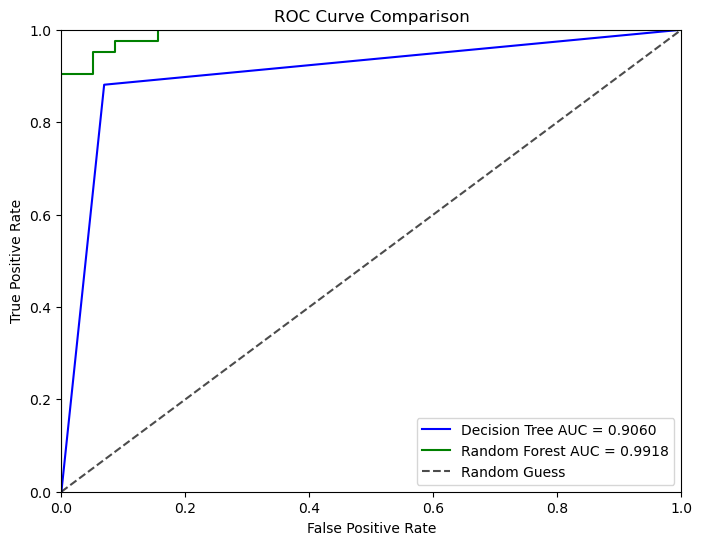

In [61]:
# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, yscores_tree_m, pos_label=1)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, yscores_rf_m, pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, 'b', label=f'Decision Tree AUC = {roc_auc_dt:.4f}')
plt.plot(fpr_rf, tpr_rf, 'g', label=f'Random Forest AUC = {roc_auc_rf:.4f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Random Guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()